<a href="https://colab.research.google.com/github/danuja-wije/A-Multi-Approach-Generalized-Framework-for-Automated-Solution-Suggestion-of-Support-Tickets/blob/master/Predictive_analysis_sqlite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from statistics import mode



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

# Connect to the SQLite database
conn = sqlite3.connect('/content/drive/MyDrive/Data mining/data.sqlite')

# Query to get the list of all tables in the database
query = "SELECT name FROM sqlite_master WHERE type='table';"

# Execute the query
tables = conn.execute(query).fetchall()
tables = [table[0] for table in tables]  # Extract table names from the tuples

# Display table names
tables


['train', 'test']

In [4]:
# Load the 'train' table into a DataFrame
train_df = pd.read_sql('SELECT * FROM train', conn)

# Display the first few rows of the DataFrame
train_df.head()


,index,Att00,Att01,Att02,Att03,Att04,Att05,Att06,Att07,Att08,...,Att21,Att22,Att23,Att24,Att25,Att26,Att27,Att28,Att29,class
0,0,-31.576673,-9.700301,-24.911617,9.081612,0,208.272079,-1.997841,1.454936,-26.600721,...,952,11.266068,-3.217048,1.783540,CDJW,0,-33.257776,-30.187609,-2.026042,1.0
1,1,-304.662214,46.607701,42.598150,-56.799268,1,-150.590555,3.867761,-2.494264,11.174107,...,101,8.088683,6.228109,NaN,CDJW,1,-49.197328,72.865869,-7.405605,0.0
2,2,-32.937870,-13.109089,-60.390007,-39.580707,1,-154.421152,-3.761358,-0.980815,-6.615842,...,-304,-8.360235,-6.056773,NaN,ASCZ,0,14.257560,69.972104,-32.162932,2.0
3,3,-78.472517,12.418401,-76.958786,-17.175313,0,222.140482,3.870460,7.106521,-8.966390,...,-352,-4.049348,6.232455,NaN,ASCZ,0,0.484677,-43.876044,-6.770418,2.0
4,4,-141.399086,29.659121,-64.726164,-3.185066,1,116.402384,-4.440180,4.239060,6.792401,...,923,20.884454,-7.149853,1.635977,CDJW,0,-38.951753,65.242059,90.457899,1.0


In [5]:
# Load the 'train' table into a DataFrame
test_df = pd.read_sql('SELECT * FROM test', conn)

# Display the first few rows of the DataFrame
test_df.head()

,index,Att00,Att01,Att02,Att03,Att04,Att05,Att06,Att07,Att08,...,Att21,Att22,Att23,Att24,Att25,Att26,Att27,Att28,Att29,class
0,5000,-157.913696,46.591821,-59.177023,42.721542,1,105.924973,2.560152,1.587294,-12.631420,...,636,-22.623987,4.122516,1.030751,CDJW,0,-37.752866,122.984572,2.884547,None
1,5001,-74.713666,27.135937,-51.311350,-35.210519,1,38.531992,-4.754808,2.257030,2.005224,...,-66,29.343850,-7.656486,0.745016,CDJW,0,-24.785175,71.980310,84.746032,None
2,5002,23.635350,26.418694,102.550297,31.062945,0,-211.500648,-11.094411,7.120198,5.894272,...,-804,2.771655,-17.864909,-0.600150,CDJW,1,8.775887,54.465244,-153.994565,None
3,5003,125.285345,-30.383228,-7.405511,-8.050738,0,-212.393798,-3.157717,-1.791073,-2.965379,...,-88,-20.657980,-5.084751,0.004201,ASCZ,1,22.335321,-51.631289,-14.704448,None
4,5004,-28.355409,156.206933,-17.591939,1.089766,0,143.473456,-6.617232,1.299314,2.491580,...,-994,8.627896,-10.655477,-1.075640,CDJW,0,19.845791,-79.317862,28.444414,None


In [6]:
# Removing the 'index' column as it is irrelevant for the analysis
train_df = train_df.drop(columns=['index'])
test_df = test_df.drop(columns=['index'])
# Display the first few rows of the updated DataFrame
train_df.head()


,Att00,Att01,Att02,Att03,Att04,Att05,Att06,Att07,Att08,Att09,...,Att21,Att22,Att23,Att24,Att25,Att26,Att27,Att28,Att29,class
0,-31.576673,-9.700301,-24.911617,9.081612,0,208.272079,-1.997841,1.454936,-26.600721,-1.470076,...,952,11.266068,-3.217048,1.783540,CDJW,0,-33.257776,-30.187609,-2.026042,1.0
1,-304.662214,46.607701,42.598150,-56.799268,1,-150.590555,3.867761,-2.494264,11.174107,5.986791,...,101,8.088683,6.228109,NaN,CDJW,1,-49.197328,72.865869,-7.405605,0.0
2,-32.937870,-13.109089,-60.390007,-39.580707,1,-154.421152,-3.761358,-0.980815,-6.615842,-6.894931,...,-304,-8.360235,-6.056773,NaN,ASCZ,0,14.257560,69.972104,-32.162932,2.0
3,-78.472517,12.418401,-76.958786,-17.175313,0,222.140482,3.870460,7.106521,-8.966390,1.312894,...,-352,-4.049348,6.232455,NaN,ASCZ,0,0.484677,-43.876044,-6.770418,2.0
4,-141.399086,29.659121,-64.726164,-3.185066,1,116.402384,-4.440180,4.239060,6.792401,-5.887968,...,923,20.884454,-7.149853,1.635977,CDJW,0,-38.951753,65.242059,90.457899,1.0


In [7]:
test_df.head()


,Att00,Att01,Att02,Att03,Att04,Att05,Att06,Att07,Att08,Att09,...,Att21,Att22,Att23,Att24,Att25,Att26,Att27,Att28,Att29,class
0,-157.913696,46.591821,-59.177023,42.721542,1,105.924973,2.560152,1.587294,-12.631420,3.115379,...,636,-22.623987,4.122516,1.030751,CDJW,0,-37.752866,122.984572,2.884547,None
1,-74.713666,27.135937,-51.311350,-35.210519,1,38.531992,-4.754808,2.257030,2.005224,5.352205,...,-66,29.343850,-7.656486,0.745016,CDJW,0,-24.785175,71.980310,84.746032,None
2,23.635350,26.418694,102.550297,31.062945,0,-211.500648,-11.094411,7.120198,5.894272,-3.254207,...,-804,2.771655,-17.864909,-0.600150,CDJW,1,8.775887,54.465244,-153.994565,None
3,125.285345,-30.383228,-7.405511,-8.050738,0,-212.393798,-3.157717,-1.791073,-2.965379,9.196558,...,-88,-20.657980,-5.084751,0.004201,ASCZ,1,22.335321,-51.631289,-14.704448,None
4,-28.355409,156.206933,-17.591939,1.089766,0,143.473456,-6.617232,1.299314,2.491580,-5.825157,...,-994,8.627896,-10.655477,-1.075640,CDJW,0,19.845791,-79.317862,28.444414,None


<Axes: >

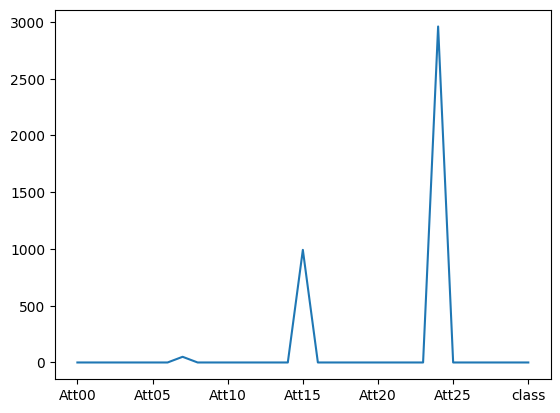

In [8]:
# Checking for missing values in each column
missing_values = train_df.isnull().sum()
missing_values.plot()


<Axes: >

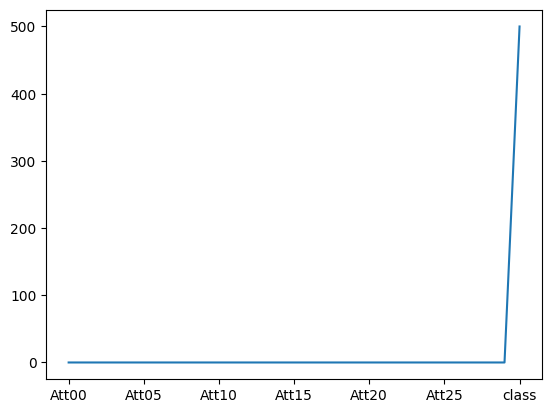

In [8]:
# Checking for missing values in each column in test
missing_values_test = test_df.isnull().sum()
missing_values_test.plot()

In [9]:
# Replacing missing values in 'Att07' with the median of the column
train_df['Att07'].fillna(train_df['Att07'].median(), inplace=True)

# Dropping 'Att15' and 'Att24' columns
train_df.drop(columns=['Att15', 'Att24'], inplace=True)

# Confirming the changes
missing_values_after = train_df.isnull().sum()
missing_values_after


Att00    0
Att01    0
Att02    0
Att03    0
Att04    0
Att05    0
Att06    0
Att07    0
Att08    0
Att09    0
Att10    0
Att11    0
Att12    0
Att13    0
Att14    0
Att16    0
Att17    0
Att18    0
Att19    0
Att20    0
Att21    0
Att22    0
Att23    0
Att25    0
Att26    0
Att27    0
Att28    0
Att29    0
class    0
dtype: int64

In [10]:
# Checking for duplicate rows
duplicate_rows = train_df.duplicated().sum()

# Checking for duplicate columns
duplicate_columns = train_df.columns.duplicated()

duplicate_rows, duplicate_columns.any()


(0, False)

In [11]:
# Checking for duplicate rows
duplicate_rows_test = test_df.duplicated().sum()

# Checking for duplicate columns
duplicate_columns_test = test_df.columns.duplicated()

duplicate_rows_test, duplicate_columns_test.any()

(0, False)

In [12]:
# Checking the data types of the attributes in the dataset
data_types = train_df.dtypes
data_types


Att00    float64
Att01    float64
Att02    float64
Att03    float64
Att04      int64
Att05    float64
Att06    float64
Att07    float64
Att08    float64
Att09    float64
Att10    float64
Att11     object
Att12      int64
Att13    float64
Att14    float64
Att16     object
Att17    float64
Att18    float64
Att19    float64
Att20    float64
Att21      int64
Att22    float64
Att23    float64
Att25     object
Att26      int64
Att27    float64
Att28    float64
Att29    float64
class    float64
dtype: object

In [13]:
# Checking the unique values in the 'Att11', 'Att16', and 'Att25' columns
unique_values_Att11 = train_df['Att11'].unique()
unique_values_Att16 = train_df['Att16'].unique()
unique_values_Att25 = train_df['Att25'].unique()

unique_values_Att11, unique_values_Att16, unique_values_Att25


(array(['NBAE', 'USGL', 'AQDH', 'LCAS', 'QQNT', 'KRNB', 'NAAU'],
       dtype=object),
 array(['ITRV', 'PWEH', 'YNCP', 'XCYU', 'FBLE', 'ZFBS', 'VVQP', 'QKNH',
        'YCQC'], dtype=object),
 array(['CDJW', 'ASCZ', 'VVFP'], dtype=object))

In [14]:
# Applying one-hot encoding to 'Att11', 'Att16', and 'Att25' columns
train_df = pd.get_dummies(train_df, columns=['Att11', 'Att16', 'Att25'], drop_first=True)

# Displaying the first few rows of the updated DataFrame
train_df.head()


,Att00,Att01,Att02,Att03,Att04,Att05,Att06,Att07,Att08,Att09,...,Att16_ITRV,Att16_PWEH,Att16_QKNH,Att16_VVQP,Att16_XCYU,Att16_YCQC,Att16_YNCP,Att16_ZFBS,Att25_CDJW,Att25_VVFP
0,-31.576673,-9.700301,-24.911617,9.081612,0,208.272079,-1.997841,1.454936,-26.600721,-1.470076,...,1,0,0,0,0,0,0,0,1,0
1,-304.662214,46.607701,42.598150,-56.799268,1,-150.590555,3.867761,-2.494264,11.174107,5.986791,...,0,1,0,0,0,0,0,0,1,0
2,-32.937870,-13.109089,-60.390007,-39.580707,1,-154.421152,-3.761358,-0.980815,-6.615842,-6.894931,...,0,0,0,0,0,0,1,0,0,0
3,-78.472517,12.418401,-76.958786,-17.175313,0,222.140482,3.870460,7.106521,-8.966390,1.312894,...,0,0,0,0,0,0,1,0,0,0
4,-141.399086,29.659121,-64.726164,-3.185066,1,116.402384,-4.440180,4.239060,6.792401,-5.887968,...,0,0,0,0,0,0,1,0,1,0


In [15]:
#applyingg encoding for test data
# Checking the unique values in the 'Att11', 'Att16', and 'Att25' columns
unique_values_Att11_test = test_df['Att11'].unique()
unique_values_Att16_test = test_df['Att16'].unique()
unique_values_Att25_test = test_df['Att25'].unique()

unique_values_Att11_test, unique_values_Att16_test, unique_values_Att25_test

(array(['QQNT', 'AQDH', 'NAAU', 'LCAS', 'NBAE', 'USGL'], dtype=object),
 array(['XCYU', 'PWEH', 'YNCP', 'ZFBS', 'ITRV', 'VVQP', 'YCQC', 'FBLE',
        'QKNH', 'MFLQ'], dtype=object),
 array(['CDJW', 'ASCZ'], dtype=object))

In [16]:
# Applying one-hot encoding to 'Att11', 'Att16', and 'Att25' Testing data columns
test_df = pd.get_dummies(test_df, columns=['Att11', 'Att16', 'Att25'], drop_first=True)

# Displaying the first few rows of the updated DataFrame
test_df.head()

,Att00,Att01,Att02,Att03,Att04,Att05,Att06,Att07,Att08,Att09,...,Att16_ITRV,Att16_MFLQ,Att16_PWEH,Att16_QKNH,Att16_VVQP,Att16_XCYU,Att16_YCQC,Att16_YNCP,Att16_ZFBS,Att25_CDJW
0,-157.913696,46.591821,-59.177023,42.721542,1,105.924973,2.560152,1.587294,-12.631420,3.115379,...,0,0,0,0,0,1,0,0,0,1
1,-74.713666,27.135937,-51.311350,-35.210519,1,38.531992,-4.754808,2.257030,2.005224,5.352205,...,0,0,1,0,0,0,0,0,0,1
2,23.635350,26.418694,102.550297,31.062945,0,-211.500648,-11.094411,7.120198,5.894272,-3.254207,...,0,0,1,0,0,0,0,0,0,1
3,125.285345,-30.383228,-7.405511,-8.050738,0,-212.393798,-3.157717,-1.791073,-2.965379,9.196558,...,0,0,1,0,0,0,0,0,0,0
4,-28.355409,156.206933,-17.591939,1.089766,0,143.473456,-6.617232,1.299314,2.491580,-5.825157,...,0,0,1,0,0,0,0,0,0,1


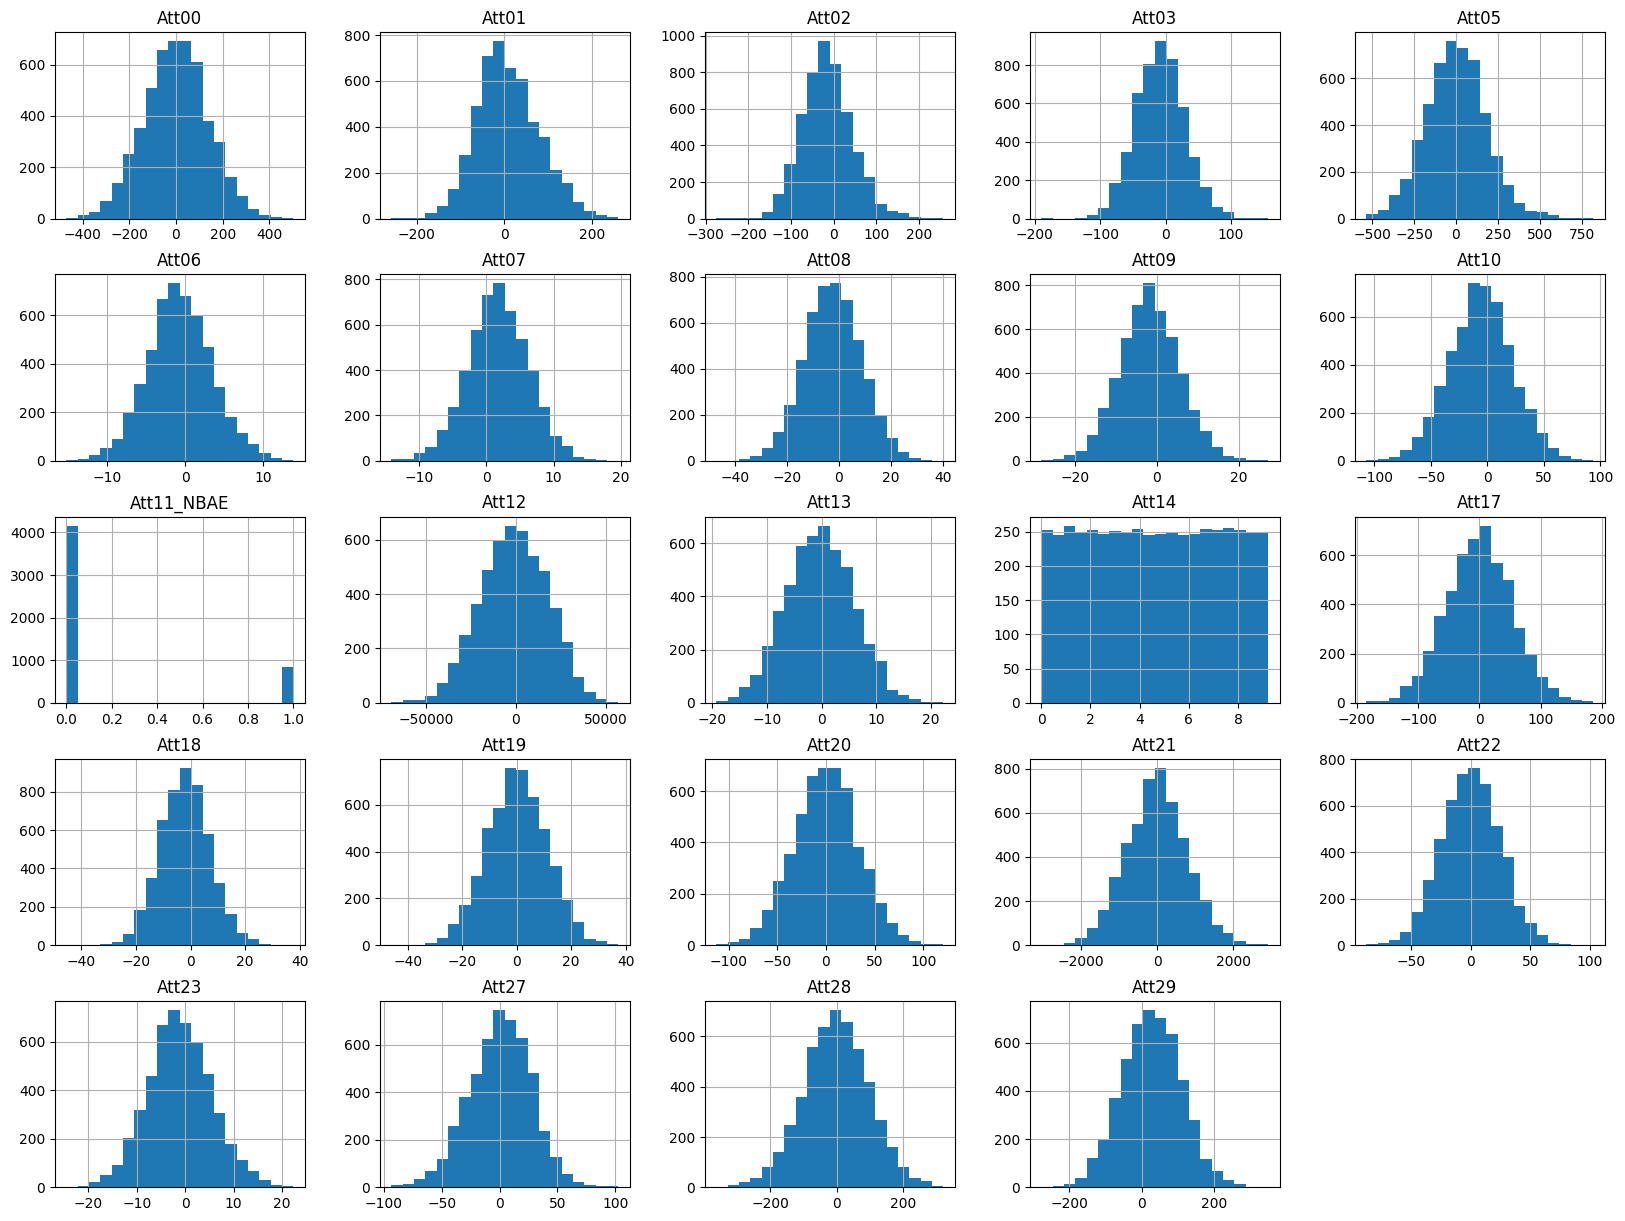

In [17]:
# Importing the necessary library for visualization

# Selecting the numerical features (excluding one-hot encoded columns and target variable)
numerical_features = train_df.columns.difference(['class', 'Att04', 'Att26',
                                                 'Att11_NAAU', 'Att11_QQNT', 'Att11_USGL', 'Att11_AQDH', 'Att11_LCAS', 'Att11_KRNB',
                                                 'Att16_FBLE', 'Att16_ITRV', 'Att16_PWEH', 'Att16_QKNH', 'Att16_VVQP', 'Att16_XCYU', 'Att16_YCQC', 'Att16_YNCP', 'Att16_ZFBS',
                                                 'Att25_CDJW', 'Att25_VVFP'])

# Plotting histograms for numerical features to observe the distribution
train_df[numerical_features].hist(bins=20, figsize=(20, 15))
plt.show()


In [18]:
# Importing the StandardScaler

# Creating the StandardScaler instance
scaler = StandardScaler()

# Applying Standard Scaling to the numerical features
train_df[numerical_features] = scaler.fit_transform(train_df[numerical_features])
test_df[numerical_features] = scaler.fit_transform(test_df[numerical_features])
# Displaying the first few rows of the scaled DataFrame
train_df.head()


,Att00,Att01,Att02,Att03,Att04,Att05,Att06,Att07,Att08,Att09,...,Att16_ITRV,Att16_PWEH,Att16_QKNH,Att16_VVQP,Att16_XCYU,Att16_YCQC,Att16_YNCP,Att16_ZFBS,Att25_CDJW,Att25_VVFP
0,-0.239238,-0.263222,-0.165376,0.462871,0,1.148737,-0.324007,-0.073003,-2.235460,0.031742,...,1,0,0,0,0,0,0,0,1,0
1,-2.230328,0.533846,0.974918,-1.296906,1,-0.852236,1.100332,-0.961993,1.234755,1.055442,...,0,1,0,0,0,0,0,0,1,0
2,-0.249162,-0.311475,-0.764634,-0.836972,1,-0.873595,-0.752240,-0.621306,-0.399533,-0.712997,...,0,0,0,0,0,0,1,0,0,0
3,-0.581159,0.049879,-1.044494,-0.238491,0,1.226065,1.100988,1.199204,-0.615468,0.413796,...,0,0,0,0,0,0,1,0,0,0
4,-1.039962,0.293930,-0.837875,0.135209,1,0.636483,-0.917078,0.553720,0.832226,-0.574758,...,0,0,0,0,0,0,1,0,1,0


In [19]:
test_df.head()

,Att00,Att01,Att02,Att03,Att04,Att05,Att06,Att07,Att08,Att09,...,Att16_ITRV,Att16_MFLQ,Att16_PWEH,Att16_QKNH,Att16_VVQP,Att16_XCYU,Att16_YCQC,Att16_YNCP,Att16_ZFBS,Att25_CDJW
0,-1.136854,0.496242,-0.799324,1.338277,1,0.591703,0.710615,-0.064401,-0.856077,0.654845,...,0,0,0,0,0,1,0,0,0,1
1,-0.534361,0.228178,-0.665512,-0.705458,1,0.205212,-1.034700,0.084406,0.465968,0.961055,...,0,0,1,0,0,0,0,0,0,1
2,0.177833,0.218296,1.951999,1.032535,0,-1.228699,-2.547299,1.164945,0.817244,-0.217117,...,0,0,1,0,0,0,0,0,0,1
3,0.913932,-0.564323,0.081419,0.006796,0,-1.233821,-0.653642,-0.815034,0.017002,1.487327,...,0,0,1,0,0,0,0,0,0,0
4,-0.198658,2.006523,-0.091874,0.246501,0,0.807040,-1.479065,-0.128387,0.509898,-0.569066,...,0,0,1,0,0,0,0,0,0,1


In [20]:
# Calculating the Pearson correlation coefficients of each feature with the target variable ('class')
correlation_with_target = train_df.corrwith(train_df['class']).sort_values(ascending=False)

# Displaying the correlation coefficients
correlation_with_target


class         1.000000
Att27         0.424021
Att00         0.414278
Att20         0.414278
Att12         0.363401
Att07         0.169944
Att16_XCYU    0.111306
Att16_VVQP    0.100985
Att29         0.061405
Att23         0.045967
Att06         0.045967
Att16_PWEH    0.045488
Att16_QKNH    0.031233
Att11_NAAU    0.030170
Att11_NBAE    0.022784
Att11_KRNB    0.012696
Att25_VVFP    0.012696
Att21         0.006097
Att22         0.002636
Att11_LCAS   -0.001940
Att28        -0.003791
Att19        -0.016753
Att11_USGL   -0.017025
Att05        -0.018792
Att11_QQNT   -0.018892
Att04        -0.020636
Att26        -0.030451
Att17        -0.037591
Att16_YCQC   -0.055269
Att01        -0.060627
Att16_YNCP   -0.076805
Att16_ZFBS   -0.110771
Att16_ITRV   -0.124679
Att08        -0.172487
Att14        -0.195188
Att02        -0.195293
Att09        -0.197169
Att18        -0.209862
Att03        -0.209862
Att10        -0.210676
Att13        -0.370700
Att25_CDJW   -0.392859
dtype: float64

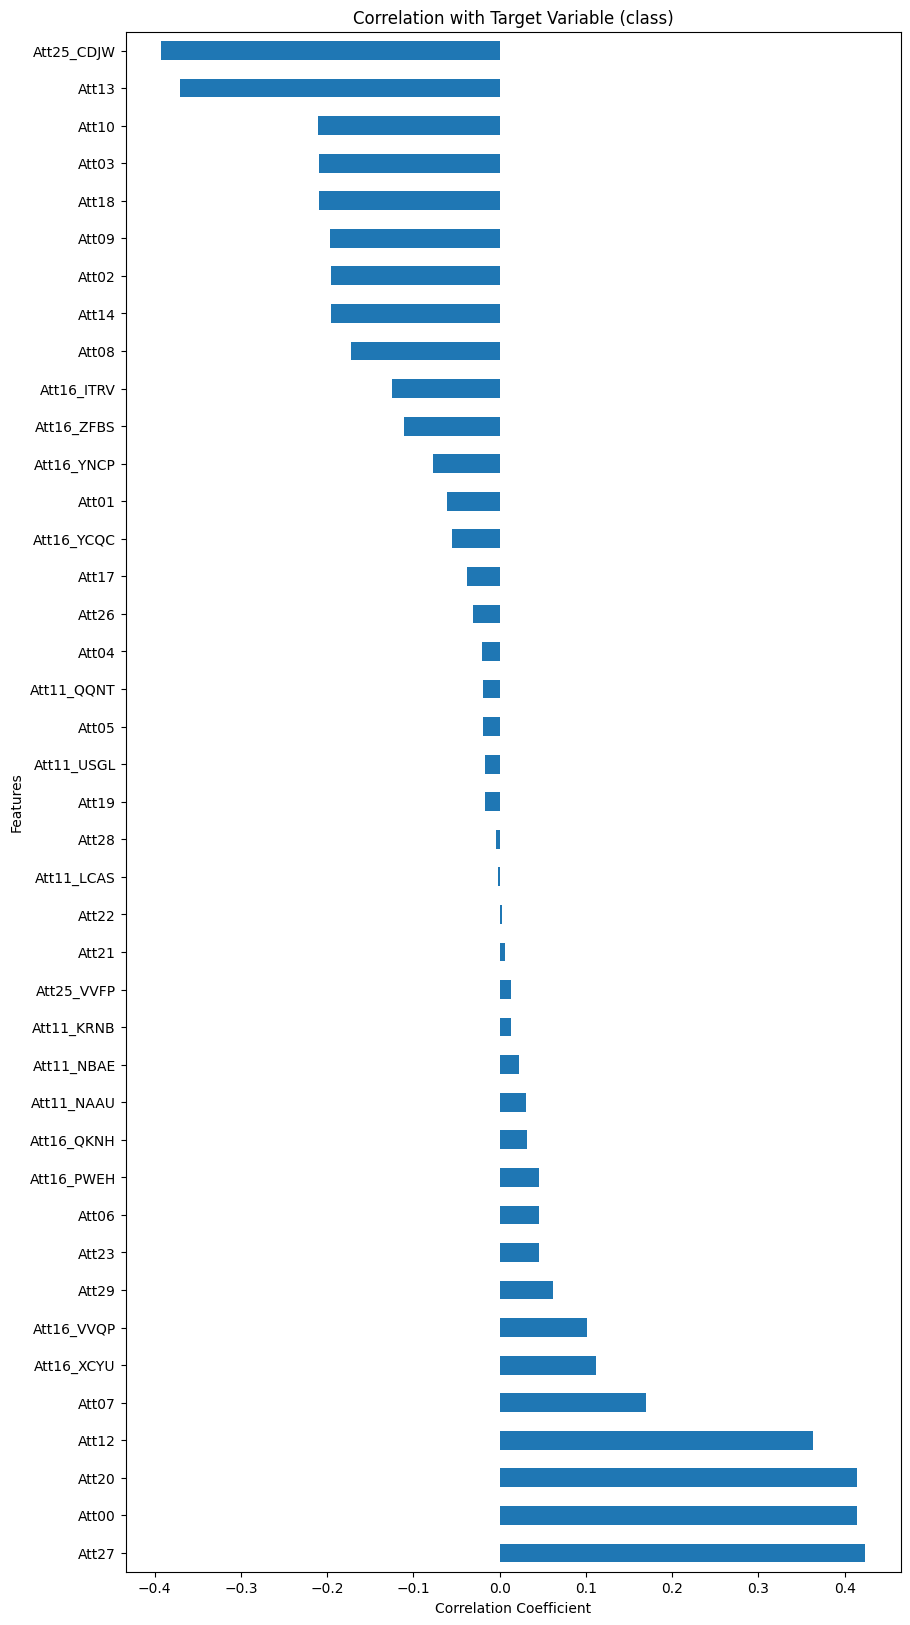

In [21]:
# Plotting the correlation coefficients with the target variable
plt.figure(figsize=(10, 20))
correlation_with_target.drop('class').plot(kind='barh')
plt.title('Correlation with Target Variable (class)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.show()


In [22]:
# Selecting features with an absolute correlation coefficient greater than 0.2
selected_features = correlation_with_target[correlation_with_target.abs() > 0.2].index

# Excluding the target variable ('class') from the selected features
selected_features = selected_features.drop('class')

# Updating the DataFrame to retain only the selected features and the target variable
selected_train_df = train_df[selected_features.tolist() + ['class']]
selected_test_df = test_df[selected_features.tolist() + ['class']]
# Displaying the first few rows of the updated DataFrame
selected_train_df.head()


,Att27,Att00,Att20,Att12,Att18,Att03,Att10,Att13,Att25_CDJW,class
0,-1.257947,-0.239238,-0.239238,-1.075694,0.462871,0.462871,-0.243341,1.771181,1,1.0
1,-1.852018,-2.230328,-2.230328,-1.676757,-1.296906,-1.296906,0.063376,0.392743,1,0.0
2,0.512962,-0.249162,-0.249162,0.293183,-0.836972,-0.836972,0.220752,-0.219347,0,2.0
3,-0.000357,-0.581159,-0.581159,-0.719884,-0.238491,-0.238491,-0.508698,-0.484165,0,2.0
4,-1.470163,-1.039962,-1.039962,-0.763741,0.135209,0.135209,0.796151,0.845018,1,1.0


In [23]:
selected_test_df.head()

,Att27,Att00,Att20,Att12,Att18,Att03,Att10,Att13,Att25_CDJW,class
0,-1.487481,-1.136854,-1.136854,-0.549775,1.338277,1.338277,0.321404,0.381789,1,None
1,-0.964986,-0.534361,-0.534361,-0.429699,-0.705458,-0.705458,0.674926,0.914308,1,None
2,0.387258,0.177833,0.177833,-0.295087,1.032535,1.032535,2.285404,0.759763,1,None
3,0.933596,0.913932,0.913932,0.850443,0.006796,0.006796,0.913883,-0.138528,0,None
4,0.833287,-0.198658,-0.198658,0.309292,0.246501,0.246501,-0.018434,1.177928,1,None


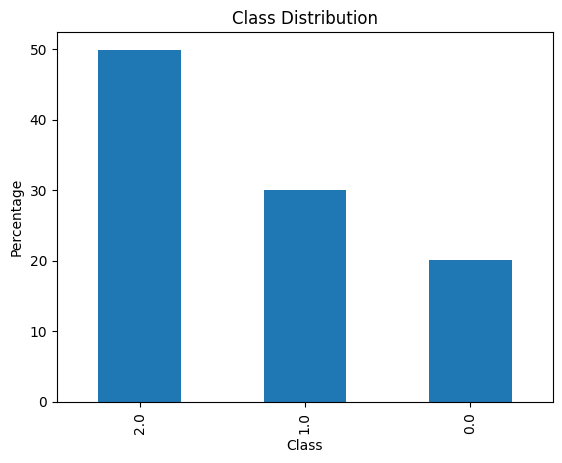

2.0    49.92
1.0    29.96
0.0    20.12
Name: class, dtype: float64

In [24]:
# Checking the distribution of the target variable ('class') to see if the classes are imbalanced
class_distribution = selected_train_df['class'].value_counts(normalize=True) * 100  # Getting the percentage distribution

# Plotting the class distribution
class_distribution.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Percentage')
plt.show()

# Displaying the class distribution
class_distribution


In [27]:

X = selected_train_df.drop(columns=['class'])
y = selected_train_df['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Initializing the additional classifiers
# Using weights='distance' for k-NN to assign higher weight to neighbors from the minority class
additional_classifiers = {
    'k-NN': KNeighborsClassifier(weights='distance'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree (re-evaluated)': DecisionTreeClassifier(class_weight='balanced', random_state=0)
}
results = {}
# Training the additional classifiers and evaluating their performance
for classifier_name, classifier in additional_classifiers.items():
    # Training the classifier
    classifier.fit(X_train, y_train)

    # Making predictions on the testing set
    y_pred = classifier.predict(X_test)

    # Calculating performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Storing the results
    results[classifier_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Combining the results and displaying
final_results_df = pd.DataFrame(results).transpose()
final_results_df


,Accuracy,Precision,Recall,F1 Score
k-NN,0.752,0.741830,0.752,0.743200
Naive Bayes,0.689,0.675463,0.689,0.669796
Decision Tree (re-evaluated),0.665,0.661226,0.665,0.662931


In [28]:

# Initializing the additional classifiers
# Using weights='distance' for k-NN to assign higher weight to neighbors from the minority class
additional_classifiers = {
    'k-NN': KNeighborsClassifier(weights='distance'),
    'Naive Bayes': GaussianNB(),
    'Decision Tree (re-evaluated)': DecisionTreeClassifier(class_weight='balanced', random_state=0)
}

# Training the additional classifiers and evaluating their performance
for classifier_name, classifier in additional_classifiers.items():
    # Training the classifier
    classifier.fit(X_train, y_train)

    # Making predictions on the testing set
    y_pred = classifier.predict(X_test)

    # Calculating performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Storing the results
    results[classifier_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Combining the results and displaying
final_results_df = pd.DataFrame(results).transpose()
final_results_df


,Accuracy,Precision,Recall,F1 Score
k-NN,0.752,0.741830,0.752,0.743200
Naive Bayes,0.689,0.675463,0.689,0.669796
Decision Tree (re-evaluated),0.665,0.661226,0.665,0.662931


In [31]:
# Initializing the additional classifiers
additional_classifiers = {
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0),
    'LightGBM': LGBMClassifier(random_state=0)
}

# Training the additional classifiers and evaluating their performance
for classifier_name, classifier in additional_classifiers.items():
    # Training the classifier
    classifier.fit(X_train, y_train)

    # Making predictions on the testing set
    y_pred = classifier.predict(X_test)

    # Calculating performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Storing the results
    results[classifier_name] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Combining the results and displaying
combined_results_df = pd.DataFrame(results).transpose()
combined_results_df

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2042
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 9
[LightGBM] [Info] Start training from score -1.603207
[LightGBM] [Info] Start training from score -1.205641
[LightGBM] [Info] Start training from score -0.694648


,Accuracy,Precision,Recall,F1 Score
k-NN,0.752,0.741830,0.752,0.743200
Naive Bayes,0.689,0.675463,0.689,0.669796
Decision Tree (re-evaluated),0.665,0.661226,0.665,0.662931
XGBoost,0.753,0.744991,0.753,0.746477
LightGBM,0.761,0.752937,0.761,0.754396


In [35]:
# Importing the resampling techniques from imbalanced-learn library


# Initializing the classifiers for re-evaluation
classifiers = {
    'Decision Tree': DecisionTreeClassifier(random_state=0),
    'k-NN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

# Defining resampling strategies
resampling_strategies = {
    'Oversampling (SMOTE)': SMOTE(random_state=0),
    'Undersampling': RandomUnderSampler(random_state=0)
}

# Initializing results dictionary
results = {}

# Applying each resampling technique (except combined) and evaluating classifiers
for resampling_name, resampler in resampling_strategies.items():
    for classifier_name, classifier in classifiers.items():
        X_resampled, y_resampled = resampler.fit_resample(X_train, y_train)
        classifier.fit(X_resampled, y_resampled)
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        results[f'{classifier_name} with {resampling_name}'] = {
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1
        }

# Applying combined sampling manually and evaluating classifiers
smote = SMOTE(random_state=0)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

for classifier_name, classifier in classifiers.items():
    classifier.fit(X_resampled, y_resampled)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    results[f'{classifier_name} with Combined Sampling'] = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Display results
for name, metrics in results.items():
    print(f"Classifier: {name}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print(f"Precision: {metrics['Precision']:.2f}")
    print(f"Recall: {metrics['Recall']:.2f}")
    print(f"F1 Score: {metrics['F1 Score']:.2f}\n")

Classifier: Decision Tree with Oversampling (SMOTE)
Accuracy: 0.69
Precision: 0.70
Recall: 0.69
F1 Score: 0.69

Classifier: k-NN with Oversampling (SMOTE)
Accuracy: 0.70
Precision: 0.72
Recall: 0.70
F1 Score: 0.71

Classifier: Naive Bayes with Oversampling (SMOTE)
Accuracy: 0.69
Precision: 0.69
Recall: 0.69
F1 Score: 0.69

Classifier: Decision Tree with Undersampling
Accuracy: 0.66
Precision: 0.69
Recall: 0.66
F1 Score: 0.67

Classifier: k-NN with Undersampling
Accuracy: 0.72
Precision: 0.74
Recall: 0.72
F1 Score: 0.73

Classifier: Naive Bayes with Undersampling
Accuracy: 0.68
Precision: 0.69
Recall: 0.68
F1 Score: 0.68

Classifier: Decision Tree with Combined Sampling
Accuracy: 0.69
Precision: 0.70
Recall: 0.69
F1 Score: 0.69

Classifier: k-NN with Combined Sampling
Accuracy: 0.70
Precision: 0.72
Recall: 0.70
F1 Score: 0.71

Classifier: Naive Bayes with Combined Sampling
Accuracy: 0.69
Precision: 0.69
Recall: 0.69
F1 Score: 0.69



In [37]:


# ... Your code for loading and preprocessing data ...

# Example: X and y are your features and labels
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Defining classifiers and their parameter grids
classifiers_param_grid = {
    'Decision Tree': (DecisionTreeClassifier(), {'max_depth': [3, 5, 7, 10, None]}),
    'k-NN': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 11]}),
    'LightGBM': (LGBMClassifier(), {'num_leaves': [31, 64], 'learning_rate': [0.01, 0.1]})
}

# Initializing results dictionary
results = {}

# Performing Grid Search for each classifier
for classifier_name, (classifier, param_grid) in classifiers_param_grid.items():
    grid_search = GridSearchCV(classifier, param_grid, cv=StratifiedKFold(n_splits=5), scoring='accuracy')
    grid_search.fit(X_train, y_train)

    # Getting the best model and predicting on test data
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Calculating metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Storing the results
    results[classifier_name] = {
        'Best Parameters': grid_search.best_params_,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Displaying the results
for classifier_name, metrics in results.items():
    print(f"Classifier: {classifier_name}")
    print(f"Best Parameters: {metrics['Best Parameters']}")
    print(f"Accuracy: {metrics['Accuracy']:.2f}")
    print(f"Precision: {metrics['Precision']:.2f}")
    print(f"Recall: {metrics['Recall']:.2f}")
    print(f"F1 Score: {metrics['F1 Score']:.2f}\n")


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000624 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2042
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 9
[LightGBM] [Info] Start training from score -1.603207
[LightGBM] [Info] Start training from score -1.206058
[LightGBM] [Info] Start training from score -0.694398
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2042
[LightGBM] [Info] Number of data points in the train set: 3200, number of used features: 9
[LightGBM] [Info] Start training from score -1.603207
[LightGBM] [Info] Start training from score -1.206058
[LightGBM] [Info] Start training from score -0.694398
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.00062

In [39]:
best_lightgbm = LGBMClassifier(num_leaves=31, learning_rate=0.1)
best_knn = KNeighborsClassifier(n_neighbors=11)


In [44]:
best_lightgbm.fit(X_train, y_train)
best_knn.fit(X_train, y_train)



[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2042
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 9
[LightGBM] [Info] Start training from score -1.603207
[LightGBM] [Info] Start training from score -1.205641
[LightGBM] [Info] Start training from score -0.694648


KNeighborsClassifier(n_neighbors=11)

In [40]:
selected_test_df = selected_test_df.drop(columns=["class"])

In [42]:
selected_test_df.head()

,Att27,Att00,Att20,Att12,Att18,Att03,Att10,Att13,Att25_CDJW
0,-1.487481,-1.136854,-1.136854,-0.549775,1.338277,1.338277,0.321404,0.381789,1
1,-0.964986,-0.534361,-0.534361,-0.429699,-0.705458,-0.705458,0.674926,0.914308,1
2,0.387258,0.177833,0.177833,-0.295087,1.032535,1.032535,2.285404,0.759763,1
3,0.933596,0.913932,0.913932,0.850443,0.006796,0.006796,0.913883,-0.138528,0
4,0.833287,-0.198658,-0.198658,0.309292,0.246501,0.246501,-0.018434,1.177928,1


In [46]:
selected_test_df.iloc[0]

Att27        -1.487481
Att00        -1.136854
Att20        -1.136854
Att12        -0.549775
Att18         1.338277
Att03         1.338277
Att10         0.321404
Att13         0.381789
Att25_CDJW    1.000000
Name: 0, dtype: float64

In [50]:
X_test_missing = selected_test_df.iloc[0]
X_test_missing

Att27        -1.487481
Att00        -1.136854
Att20        -1.136854
Att12        -0.549775
Att18         1.338277
Att03         1.338277
Att10         0.321404
Att13         0.381789
Att25_CDJW    1.000000
Name: 0, dtype: float64

In [52]:
X_test_missing = np.array(X_test_missing).reshape(1,-1)
X_test_missing

array([[-1.48748131, -1.13685374, -1.13685374, -0.54977479,  1.33827666,
         1.33827666,  0.32140356,  0.38178915,  1.        ]])

In [53]:
lightgbm_predictions = best_lightgbm.predict(X_test_missing)
knn_predictions = best_knn.predict(X_test_missing)


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


In [54]:
lightgbm_predictions

array([1.])

In [55]:
knn_predictions

array([1.])

In [67]:
selected_test_df = selected_test_df.drop(columns=["Predicted_Label"])

In [68]:
predictions_data = []

# Loop over each row in the DataFrame
for index, row in selected_test_df.iterrows():
    # Reshape the row to 2D array as the model expects 2D input
    sample = row.values.reshape(1, -1)

    # Make predictions with both models
    lightgbm_pred = best_lightgbm.predict(sample)
    knn_pred = best_knn.predict(sample)

    # Store the index and predictions
    predictions_data.append({
        'Index': index,
        'Predict1': lightgbm_pred[0],
        'Predict2': knn_pred[0]
    })

# Convert the predictions data to a DataFrame
predictions_df = pd.DataFrame(predictions_data)

/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:594: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:594: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning("Usage of np.ndarray subset (sliced data) is not recommended "
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:594: UserWarning: Usage of np.ndarra

In [70]:
predictions_df.head()

,Index,Predict1,Predict2
0,0,1.0,1.0
1,1,1.0,1.0
2,2,2.0,2.0
3,3,2.0,2.0
4,4,1.0,1.0


In [60]:
selected_test_df.head()

,Att27,Att00,Att20,Att12,Att18,Att03,Att10,Att13,Att25_CDJW,Predicted_Label
0,-1.487481,-1.136854,-1.136854,-0.549775,1.338277,1.338277,0.321404,0.381789,1,1.0
1,-0.964986,-0.534361,-0.534361,-0.429699,-0.705458,-0.705458,0.674926,0.914308,1,1.0
2,0.387258,0.177833,0.177833,-0.295087,1.032535,1.032535,2.285404,0.759763,1,2.0
3,0.933596,0.913932,0.913932,0.850443,0.006796,0.006796,0.913883,-0.138528,0,2.0
4,0.833287,-0.198658,-0.198658,0.309292,0.246501,0.246501,-0.018434,1.177928,1,1.0


In [71]:
conn = sqlite3.connect('Answers.sqlite')

# Create a new SQLite table with name 'predictions'
predictions_df.to_sql('predictions', conn, if_exists='replace', index=False)

# Verify that the data is stored correctly
cursor = conn.cursor()
cursor.execute("SELECT * FROM predictions")
rows = cursor.fetchall()

# Display the rows from the database
for row in rows:
    print(row)

# Close the connection to the database
conn.close()

(0, 1.0, 1.0)
(1, 1.0, 1.0)
(2, 2.0, 2.0)
(3, 2.0, 2.0)
(4, 1.0, 1.0)
(5, 0.0, 1.0)
(6, 2.0, 2.0)
(7, 1.0, 1.0)
(8, 1.0, 1.0)
(9, 1.0, 1.0)
(10, 2.0, 2.0)
(11, 1.0, 1.0)
(12, 1.0, 1.0)
(13, 1.0, 2.0)
(14, 2.0, 2.0)
(15, 2.0, 2.0)
(16, 0.0, 0.0)
(17, 2.0, 2.0)
(18, 1.0, 1.0)
(19, 2.0, 2.0)
(20, 1.0, 1.0)
(21, 2.0, 2.0)
(22, 2.0, 2.0)
(23, 0.0, 1.0)
(24, 2.0, 2.0)
(25, 2.0, 2.0)
(26, 2.0, 2.0)
(27, 2.0, 2.0)
(28, 1.0, 1.0)
(29, 2.0, 2.0)
(30, 2.0, 2.0)
(31, 1.0, 1.0)
(32, 2.0, 2.0)
(33, 2.0, 1.0)
(34, 1.0, 1.0)
(35, 2.0, 2.0)
(36, 2.0, 2.0)
(37, 0.0, 1.0)
(38, 1.0, 1.0)
(39, 2.0, 2.0)
(40, 2.0, 2.0)
(41, 2.0, 2.0)
(42, 2.0, 2.0)
(43, 1.0, 1.0)
(44, 1.0, 1.0)
(45, 2.0, 2.0)
(46, 0.0, 0.0)
(47, 2.0, 2.0)
(48, 2.0, 2.0)
(49, 0.0, 0.0)
(50, 2.0, 2.0)
(51, 0.0, 0.0)
(52, 1.0, 0.0)
(53, 0.0, 0.0)
(54, 2.0, 2.0)
(55, 2.0, 2.0)
(56, 2.0, 2.0)
(57, 0.0, 2.0)
(58, 2.0, 2.0)
(59, 1.0, 1.0)
(60, 2.0, 2.0)
(61, 2.0, 2.0)
(62, 0.0, 0.0)
(63, 2.0, 2.0)
(64, 2.0, 2.0)
(65, 2.0, 2.0)
(66, 1.0, 1.0)
(67, 